In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math 


class ResNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return x + self.net(x)


class Conv2DBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, s, p),
            nn.BatchNorm2d(out_ch),
            nn.ELU(),
        )

    def forward(self, x):
        return self.net(x)


class RepresentationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # (1, 64, 64)
            Conv2DBlock(1, 128, 4, 2),  # (128, 32, 32)
            ResNet(Conv2DBlock(128, 128, 3)),
            Conv2DBlock(128, 256, 4, 2),  # (256, 16, 16)
            ResNet(Conv2DBlock(256, 256, 3)),
            Conv2DBlock(256, 512, 4, 2),  # (512, 8, 8)
            ResNet(Conv2DBlock(512, 512, 3)),
        )

    def forward(self, x):
        return self.net(x)


class TransformModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(
            nn.Conv2d(512, 512, 1, 1, 0),  # (512, 8, 8)
            nn.ELU(),
        )
        self.net2 = nn.Sequential(
            nn.ConvTranspose3d(512, 512, 1, 1, 0),  # (512, 8, 8, 1)
            nn.ELU(),
        )

    def forward(self, x):
        x = self.net1(x)
        x = x.view(-1, 512, 8, 8, 1)
        x = self.net2(x)
        return x


class Deconv3DBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose3d(in_ch, out_ch, k, s, p),
            nn.BatchNorm3d(out_ch),
            nn.ELU(),
        )

    def forward(self, x):
        return self.net(x)


class GenerationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # (512, 8, 8, 1)
            Deconv3DBlock(512, 256, 4, 2),  # (256, 16, 16, 2)
            Deconv3DBlock(256, 256, 3),
            Deconv3DBlock(256, 128, 4, 2),  # (128, 32, 32, 4)
            Deconv3DBlock(128, 128, 3),
            Deconv3DBlock(128, 64, 4, 2),  # (64, 64, 64, 8)
            Deconv3DBlock(64, 64, 3),
            nn.Conv3d(64, 1, 1, 1, 0),  # (1, 64, 64, 8)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


class ReconstructionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            RepresentationNetwork(),
            TransformModule(),
            GenerationNetwork(),
        )

    def forward(self, x):
        return self.net(x)


In [2]:
import torch
import numpy as np
import nibabel as ni
import os, shutil
import time
import random
import pandas as pd 

def split_train_test(dir, ratio_test=0.15):
    if os.path.exists(os.path.join(dir, "train")):
        return
    os.mkdir(os.path.join(dir, "train"))
    if not os.path.exists(os.path.join(dir, "test")):
        return
    os.mkdir(os.path.join(dir, "test"))
    
    images_list = [i for i in os.listdir(dir) if i.endswith(".nii")]

    random.shuffle(images_list)
    threshold = int(len(images_list)*ratio_test)
    train_list = images_list[:-threshold]
    test_list = images_list[-threshold:]

    for i in train_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "train", i))
    for i in test_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "test", i))

def save_data_to_csv(dir, z):
    pd.DataFrame(z).to_csv(dir, header=None, index=False)

def load_mri_images(path, batch_size):
    filenames = [i for i in os.listdir(path) if i.endswith("orig.nii")]
    random.shuffle(filenames)
    n = 0
    pool = nn.AvgPool3d(8)
    while n < len(filenames):
        batch_image = []
        for i in range(n, n + batch_size):
            if i >= len(filenames):
                ##n = i
                break
            image = ni.load(os.path.join(path, filenames[i]))
            image = np.array(image.dataobj)
            depth = image.shape[2]
            image = torch.Tensor(image)[:, :, depth//2-32:depth//2+32]  # (512, 512, 64)
            image = (image - image.min()) / (image.max() - image.min())
            image = torch.reshape(image, (1, 1, 512, 512, 64))
            image = pool(image)  # (64, 64, 8)
            batch_image.append(image)
        n += batch_size
        batch_image = torch.cat(batch_image, axis=0)
        yield batch_image


In [3]:
start = time.time()
for i in load_mri_images("../ircad-dataset/train/", 2):
    print(time.time()-start)
    start = time.time()
    print(i.shape)

split_train_test("../ircad-dataset")

0.5349681377410889
torch.Size([2, 1, 64, 64, 8])
0.5376121997833252
torch.Size([2, 1, 64, 64, 8])
0.4889099597930908
torch.Size([2, 1, 64, 64, 8])
0.5046861171722412
torch.Size([2, 1, 64, 64, 8])
0.5307953357696533
torch.Size([2, 1, 64, 64, 8])
0.5159714221954346
torch.Size([2, 1, 64, 64, 8])
0.5394420623779297
torch.Size([2, 1, 64, 64, 8])
0.5094788074493408
torch.Size([2, 1, 64, 64, 8])


In [4]:
"""
Author: Duy-Phuong Dao
Email: phuongdd.1997@gmail.com (or duyphuongcri@gmail.com)
"""

import nibabel as ni
import numpy as np
import os, glob
import torch
import csv
import random
from tqdm import tqdm

##---------Settings--------------------------
batch_size = 64
lrate = 0.01
epochs = 2000
weight_decay = 5e-7
##############
path_data = "../ircad-dataset/train"
path2save = "./checkpoint/3drec-cont_{}.pt"
dir_info = './infor'       
f = open(os.path.join(dir_info,'3drec-cont_t1.csv'),'w',newline='')


####################
log = print
np.random.seed(10)
torch.manual_seed(10)
###################
criterion = nn.MSELoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(" GPU is activated" if device else " CPU is activated")
no_images = len(glob.glob(path_data + "/*.nii"))
print("Number of MRI images: ", no_images)

model = ReconstructionNetwork()
model.to(device)
#log(vae_model)
optimizer = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)
for epoch in range(epochs):
    loss_epoch = 0
    
    # training phrase
    model.train()
    for batch_images in load_mri_images(path_data, batch_size):
        optimizer.zero_grad()
        batch_images = batch_images.to(device)
        y = model(batch_images[:, :, :, :, 4])
        
        # Measure loss
        loss = criterion(batch_images, y)

        # Optimize
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item() * batch_images.shape[0]

    # save model
    log_info = (epoch + 1, epochs, loss_epoch/no_images)
    log('%d/%d  Reconstruction Loss %.3f'% log_info)
    if (epoch+1) % 100 == 0:
        torch.save(model, path2save.format(epoch+1))  

    # write csv
    writer = csv.writer(f)
    writer.writerow([epoch + 1, '{:04f}'.format(loss_epoch/no_images)])
f.close()

 GPU is activated
Number of MRI images:  34
1/2000  Reconstruction Loss 0.055
2/2000  Reconstruction Loss 0.037
3/2000  Reconstruction Loss 0.049
4/2000  Reconstruction Loss 0.036
5/2000  Reconstruction Loss 0.029
6/2000  Reconstruction Loss 0.026
7/2000  Reconstruction Loss 0.024
8/2000  Reconstruction Loss 0.021
9/2000  Reconstruction Loss 0.019
10/2000  Reconstruction Loss 0.019
11/2000  Reconstruction Loss 0.017
12/2000  Reconstruction Loss 0.015
13/2000  Reconstruction Loss 0.013
14/2000  Reconstruction Loss 0.013
15/2000  Reconstruction Loss 0.013
16/2000  Reconstruction Loss 0.012
17/2000  Reconstruction Loss 0.011
18/2000  Reconstruction Loss 0.010
19/2000  Reconstruction Loss 0.010
20/2000  Reconstruction Loss 0.010
21/2000  Reconstruction Loss 0.010
22/2000  Reconstruction Loss 0.010
23/2000  Reconstruction Loss 0.010
24/2000  Reconstruction Loss 0.009
25/2000  Reconstruction Loss 0.009
26/2000  Reconstruction Loss 0.009
27/2000  Reconstruction Loss 0.009
28/2000  Reconstruct

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
import nibabel as ni 
import torch

def display_image(x, y):
    assert x.shape == y.shape
    if x.dim() == 5:
        x = torch.reshape(x, (x.shape[0], 64, 64, 8)).cpu().detach().numpy()
        y = torch.reshape(y, (y.shape[0], 64, 64, 8)).cpu().detach().numpy()
        for i in range(len(x)):
            rows = 2
            columns = 1
            fig=plt.figure()
            for idx in range(rows*columns):
                fig.add_subplot(rows, columns, idx+1)
                if idx < columns:
                    plt.imshow(x[i, :, :, 4], cmap="gray", origin="lower")
                else:
                    plt.imshow(y[i, :, :, 4], cmap="gray", origin="lower")
            plt.show()


 GPU is activated
Number of MRI images:  6


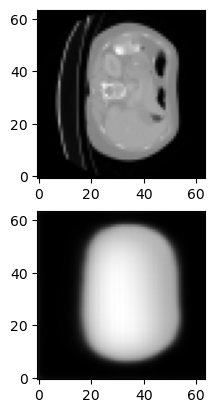

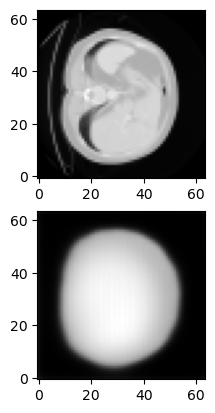

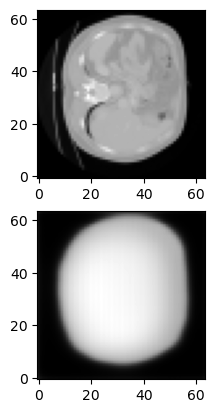

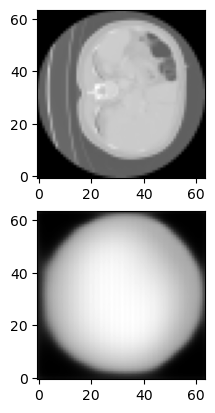

Loss: 0.0061


In [7]:
import nibabel as ni
import numpy as np
import os, glob
import torch 
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt 

batch_size = 1
path_data = "../ircad-dataset/test"
path_model = "./checkpoint/3drec-cont_1400.pt"

log = print
np.random.seed(10)
torch.manual_seed(10)

criterion_dis = nn.MSELoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(" GPU is activated" if device else " CPU is activated")
no_images = len(glob.glob(path_data + "/*.nii"))
print("Number of MRI images: ", no_images)

model = torch.load(path_model)
model.to(device)
total_loss = 0
    
# interfere phrase
model.eval()
with torch.no_grad():
    for batch_images in load_mri_images(path_data, batch_size):
        batch_images = batch_images.to(device)
        y = model(batch_images[:, :, :, :, 4])

        # Measure loss
        loss = criterion(batch_images, y)

        total_loss += loss.item() * batch_images.shape[0]

        # display
        display_image(batch_images, y)

print("Loss: {:.4f}".format(total_loss/ no_images))
